In [78]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="USDT_BTC",
                  #start=string2ts("2017-10-01 00:00:00"),
                  start=1502427600,
                  end=string2ts("2018-04-18 00:00:00"),
                  period=3600/4)


per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
 

df["ho"] = df["high"]-df["open"]
df["lo"] = df["low"]-df["open"]

tf_1 = df.shift(-1)

df["outcome"] = (tf_1["close"]>tf_1["open"])
#df["outcome"] = (df["close"]>df["open"])


ts_1 = df.shift(1)
ts_2 = df.shift(2)

#df["feat1"] = ts_1["close"] > ts_1["open"]
#df["feat2"] = ts_1["close"] > ts_2["open"]

df["feat1"] = df["close"] > ts_1["close"]
df["feat2"] = df["close"] > ts_2["close"]

#df["gain"] = df["close"] - df["open"]
df["gain"] = (tf_1["close"] - tf_1["open"])

#df[["close", "open"]].head(16)

In [79]:
from stockstats import StockDataFrame
from profit import profit
from mldata import ml_data
from orders import orders

stock = StockDataFrame.retype(df.copy())

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"].shift(-1),"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"].shift(-1),
                          "wr":stock["wr_14"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"], "log_return":marketReturn(df["close"]), "feat1":df["feat1"], "feat2":df["feat2"], 
                          "ideal_w2":df["outcome"], "gain":df["gain"], "lo":df["lo"], "open":df["open"]})


data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

fe2 = ["feat1", "feat2", "gain"]
features = ["feat1", "feat2", "cci", "rsi"]

train2, test2 = df[1:int(len(data)*per)], df[int(len(data)*per):]

X_train, y_train, X_test, y_test = train[features], train["ideal_w2"], test[features], test["ideal_w2"]
X_train2, X_test2 = train[fe2], test[fe2]

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)

# solo cogiendo feat1 y feat2, no cogiendo gain
clf.fit(X_train, y_train)

pre_proba = clf.predict_proba(X_test)

pre = clf.predict(X_test)

accuracy_score(test2["outcome"], pre)

0.62177173007497921

In [81]:
def trade_with_stop(bar, fee = 0, stop=None):
    """
    Given a bar, with a gain obtained by the closing price - opening price
    it applies a stop limit order to limit a negative loss
    If stop is equal to None, then it returns bar['gain']
    """
    bar['gain'] = bar['gain']*(1-2*fee)
    if stop<>None:
        real_stop = (stop)*(1-2*fee)
        if bar['lo']<=-stop:
            #print "real_stop", -real_stop, "lo", bar["lo"], "gain", bar["gain"]
            return real_stop
    # stop == None    
    return bar['gain']

In [82]:
STOP = 50
threshold = 0.5
FEE = 0.0015

w = pd.DataFrame(data={"pre":pre ,"close":test["close"], "w_prob":pre_proba[:,1], "outcome":test2["outcome"]})

trades = test[w["pre"]==1][["gain", "close", "lo", "open"]]
trades["pnl"] = trades.apply(lambda x: trade_with_stop(x, FEE, STOP), axis=1)
pnl = test[w["pre"]==1]["gain"]

print "Profit:", pnl.cumsum()[-2]/w["close"][0]*100
print "Profit con FEE:", trades["pnl"].cumsum()[-2]/w["close"][0]*100
print "Número de trades:", len(pnl), "+razón de entrada:", float(len(pnl))/len(test)

Profit: 233.960512278
Profit con FEE: 341.640916259
Número de trades: 1729 +razón de entrada: 0.480144404332


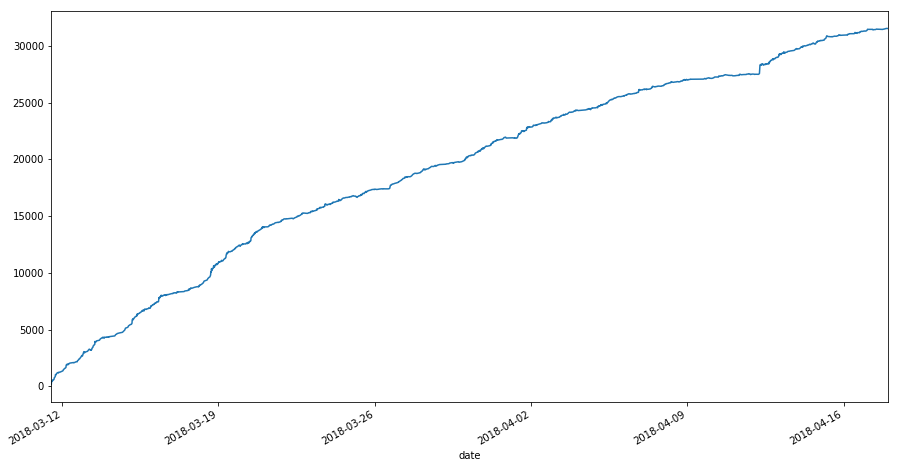

In [83]:
trades["pnl"].cumsum().plot()

In [84]:
pnl.cumsum()[-1]

21584.742592219991

In [85]:
w.head(25)

,close,outcome,pre,w_prob
date,,,,
2018-03-11 12:00:00,9224.279698,True,True,0.911335
2018-03-11 12:15:00,9425.000000,False,True,0.862956
2018-03-11 12:30:00,9384.100000,True,True,0.954712
2018-03-11 12:45:00,9610.000001,True,True,0.816093
2018-03-11 13:00:00,9651.461686,False,True,0.667129
2018-03-11 13:15:00,9614.999998,True,True,0.718640
2018-03-11 13:30:00,9600.000000,True,True,0.847211
2018-03-11 13:45:00,9609.999998,False,True,0.644202
2018-03-11 14:00:00,9578.867778,True,True,0.691669


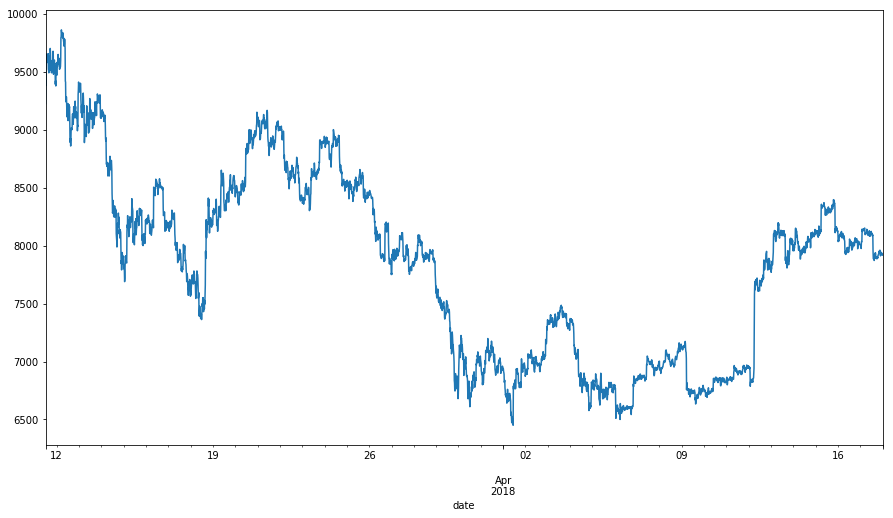

In [86]:
w["close"].plot()

In [87]:
df2 = df.copy()

In [88]:
df2["outcome2"] = (df2["close"]>df2["open"]).shift(-1)


df2["feat1_2"] = df2["close"] > ts_1["close"]
df2["feat2_2"] = df2["close"] > ts_2["close"]

df2[["outcome", "feat1", "feat2", "outcome2", "feat1_2", "feat2_2"]].head(17)

,outcome,feat1,feat2,outcome2,feat1_2,feat2_2
date,,,,,,
2017-08-11 00:00:00,True,False,False,True,False,False
2017-08-11 00:15:00,True,True,False,True,True,False
2017-08-11 00:30:00,True,True,True,True,True,True
2017-08-11 00:45:00,False,True,True,False,True,True
2017-08-11 01:00:00,False,False,True,False,False,True
2017-08-11 01:15:00,True,False,False,True,False,False
2017-08-11 01:30:00,False,True,False,False,True,False
2017-08-11 01:45:00,True,False,True,True,False,True
2017-08-11 02:00:00,True,True,True,True,True,True
